# Coding a Transformer from Scratch

Giorgio Lazzarinetti - My Contacts
For any questions or doubts you can find my contacts here:

giorgiolazzarinetti@gmail.com g.lazzarinetti@campus.unimib.it

## Notebook Outline

- **Multi Head Attention step by step**
- **Transformer from scratch**
- **Transformer with Torch.nn.Transformers**
- **Pre-trained Transformer - Contextual Word Embedding**
- **LAB CHALLENGE 4: Recommender System with Attention**





Some refs:

* Original Paper: [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf);

* [The Illustrated Transformer - Jay Alammar.](http://jalammar.github.io/illustrated-transformer/)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#from torchtext.legacy import data, datasets
from torchtext import vocab

#from torchtext import data, datasets

import numpy as np
import random, tqdm, sys, math, gzip
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
#use_cuda = torch.cuda.is_available()
device = torch.device("cpu")

## Multi-head Attention Mechanism, step by step

Before looking at how to implement self-attention and multi-head attention, let's understand how attention works.

Say the following sentence is an input sentence we want to translate:

`The animal didn't cross the street because it was too tire`

What does “it” in this sentence refer to? Is it referring to the street or to the animal? It’s a simple question to a human, but not as simple to an algorithm.

When the model is processing the word “it”, self-attention allows it to associate “it” with “animal”.

As the model processes each word (each position in the input sequence), self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word.

### Self-Attention in Detail

Let’s first look at how to calculate self-attention using vectors, then proceed to look at how it’s actually implemented – using matrices.

The **first step** in calculating self-attention is to create three vectors from each of the encoder’s input vectors (in this case, the embedding of each word). So for each word, we create a Query vector, a Key vector, and a Value vector. These vectors are created by multiplying the embedding by three matrices that we trained during the training process.


<center>  <img src="https://drive.google.com/uc?export=view&id=1N7XrMctFitVRKkqj_FoXs0GA_AlaVp06" width="750" height="550"> </center>

What are the “query”, “key”, and “value” vectors?

They’re abstractions that are useful for calculating and thinking about attention. Once you proceed with reading how attention is calculated below, you’ll know pretty much all you need to know about the role each of these vectors plays.

The **second step** in calculating self-attention is to calculate a score. Say we’re calculating the self-attention for the first word in this example, “Thinking”. We need to score each word of the input sentence against this word. The score determines how much focus to place on other parts of the input sentence as we encode a word at a certain position.

The score is calculated by taking the dot product of the query vector with the key vector of the respective word we’re scoring. So if we’re processing the self-attention for the word in position #1, the first score would be the dot product of q1 and k1. The second score would be the dot product of q1 and k2.

The **third and fourth steps** are to divide the scores by the square root of the dimension of the key vectors. This leads to having more stable gradients. There could be other possible values here, but this is the default. Then pass the result through a softmax operation. Softmax normalizes the scores so they’re all positive and add up to 1.

This softmax score determines how much each word will be expressed at this position. Clearly the word at this position will have the highest softmax score, but sometimes it’s useful to attend to another word that is relevant to the current word.


The **fifth step** is to multiply each value vector by the softmax score (in preparation to sum them up). The intuition here is to keep intact the values of the word(s) we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers like 0.001, for example).

The **sixth step** is to sum up the weighted value vectors. This produces the output of the self-attention layer at this position (for the first word).

When dealing with matrices The *first step* is to calculate the Query, Key, and Value matrices. We do that by packing our embeddings into a matrix X, and multiplying it by the weight matrices we’ve trained (WQ, WK, WV). Finally, since we’re dealing with matrices, we can condense steps two through six in one formula to calculate the outputs of the self-attention layer.

<center>  <img src="https://drive.google.com/uc?export=view&id=1Xyl9DiN_n_CgJwgrfymaVmAXA2UMInIP" width="750" height="350"> </center>



First, let's set some hyperparameters. To keep it simple we choose small size hyperparameters.

In [3]:
emb = 128 # embedding dimension (BERT like models 768)
h = 8 # number of heads (BERT has 12 heads)

batch_size = 4
sentence_length = 21 # 512 for BERT

Some fake random data with proper dimensions

In [4]:
x = torch.rand(batch_size, 21, emb)

b, t, e = x.size()

In [5]:
x.size()

torch.Size([4, 21, 128])

Instantiate linear transformations for query, key and values. Each transformation will act on the input vector x.

In [6]:
tokeys    = nn.Linear(emb, emb, bias=False) # W_key
toqueries = nn.Linear(emb, emb, bias=False) # W_query
tovalues  = nn.Linear(emb, emb, bias=False) # W_value

Generate queries, keys and values. We first compute the k/q/v's on the whole embedding vectors, and then split into the different heads.

In [7]:
keys    = tokeys(x) # W_key x
queries = toqueries(x)
values  = tovalues(x)

In [8]:
print(keys.size())

torch.Size([4, 21, 128])


Implement now multi-head attention (the ligther version), splitting into the different heads.

Self-attention layer can be further refined by adding a mechanism called “multi-headed” attention. This improves the performance of the attention layer in two ways:

- It expands the model’s ability to focus on different positions. Yes, in the example above, z1 contains a little bit of every other encoding, but it could be dominated by the actual word itself. If we’re translating a sentence like “The animal didn’t cross the street because it was too tired”, it would be useful to know which word “it” refers to.

- It gives the attention layer multiple “representation subspaces”. As we’ll see next, with multi-headed attention we have not only one, but multiple sets of Query/Key/Value weight matrices (the Transformer uses eight attention heads, so we end up with eight sets for each encoder/decoder). Each of these sets is randomly initialized. Then, after training, each set is used to project the input embeddings (or vectors from lower encoders/decoders) into a different representation subspace.

In [9]:
s = e // h # 128 / 8

keys    = keys.view(b, t, h, s)
queries = queries.view(b, t, h, s)
values  = values.view(b, t, h, s)

print(keys.size())

torch.Size([4, 21, 8, 16])


In [10]:
keys.transpose(1, 2).size()

torch.Size([4, 8, 21, 16])

In [11]:
keys.transpose(1, 2).contiguous().view(b * h, t, s).size()

torch.Size([32, 21, 16])

We need now to compute the dot products. This is the same operation for every head, so we fold the heads into the batch dimension.

In [12]:
keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
values = values.transpose(1, 2).contiguous().view(b * h, t, s)

# contiguous():  it actually makes a copy of the tensor such that the order of
# its elements in memory is the same as if it had been created from scratch with the same data.
# transpose(1, 2) doesn't generate a new tensor with a new layout, it just
# modifies meta information in the Tensor object so that the offset and stride describe the desired new shape.
# https://discuss.pytorch.org/t/contigious-vs-non-contigious-tensor/30107

keys.size()

torch.Size([32, 21, 16])

Perform dot products

In [13]:
print(queries.size())

print(keys.transpose(1, 2).size())

#Let's compute the attention matrix
dot = torch.bmm(queries, keys.transpose(1, 2)).size()  # batch matrix-matrix product

print(dot)

torch.Size([32, 21, 16])
torch.Size([32, 16, 21])
torch.Size([32, 21, 21])


Just for completeness, below the implementation of the original multi-head attention (which is wide and computationally more intensive).

In [14]:
emb = 128
h = 8

x = torch.rand(4, 21, emb)

b, t, e = x.size()

tokeys    = nn.Linear(emb, emb * h, bias=False)
toqueries = nn.Linear(emb, emb * h, bias=False)
tovalues  = nn.Linear(emb, emb * h, bias=False)

keys    = tokeys(x)
queries = toqueries(x)
values  = tovalues(x)

print(keys.size())

keys    = keys.view(b, t, h, e)
queries = queries.view(b, t, h, e)
values  = values.view(b, t, h, e)

print(keys.size())


torch.Size([4, 21, 1024])
torch.Size([4, 21, 8, 128])


### Model Definition

Let us collect everything and define the self-attention class

In [15]:
class MHSelfAttention(nn.Module):
    """
    Multi-head self attention.
    """

    def __init__(self, emb, heads=8):
        """
        :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()

        assert emb % heads == 0, f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'

        self.emb = emb
        self.heads = heads

        #s = emb // heads
        # - We will break the embedding into `heads` chunks and feed each to a different attention head

        self.tokeys    = nn.Linear(emb, emb, bias=False)
        self.toqueries = nn.Linear(emb, emb, bias=False)
        self.tovalues  = nn.Linear(emb, emb, bias=False)

        self.unifyheads = nn.Linear(emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        s = e // h

        # We first compute the k/q/v's on the whole embedding vectors, and then split into the different heads.

        keys    = self.tokeys(x)
        queries = self.toqueries(x)
        values  = self.tovalues(x)

        # Split into the different heads.

        keys    = keys.view(b, t, h, s)
        queries = queries.view(b, t, h, s)
        values  = values.view(b, t, h, s)

        # Compute scaled dot-product self-attention

        # Fold heads into the batch dimension
        # When you call contiguous(), it actually makes a copy of the tensor
        # such that the order of its elements in memory is the same as if it had been created from scratch with the same data.
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values = values.transpose(1, 2).contiguous().view(b * h, t, s)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        # This should be more memory efficient

        # Get dot product of queries and keys, and scale.

        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b * h, t, t)

        dot = F.softmax(dot, dim=2) # Dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, s)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, s * h)

        return self.unifyheads(out)

## Transformer from Scratch

A Transformer Block is based on self-attention (and Layer Normalization, Residual Connections)

<center>  <img src="https://drive.google.com/uc?export=view&id=1fiJjl6ZfaoWZu_K44-vI6UoN5UV5SwUs" width="350" height="550"> </center>

A transformer model is based on the **Encoder-Decoder Framework**. in general the encodinc component can be considered as a stack of encoder while the decoder as a stack of decoding components.

### The Encoder
The encoder’s inputs first flow through a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word.

The outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position.

### The Decoder
The decoder has both those layers, but between them is an attention layer that helps the decoder focus on relevant parts of the input sentence.

### Input Embedding
The embedding only happens in the bottom-most encoder. The abstraction that is common to all the encoders is that they receive a list of vectors each of the size 512 – In the bottom encoder that would be the word embeddings, but in other encoders, it would be the output of the encoder that’s directly below. The size of this list is hyperparameter we can set – basically it would be the length of the longest sentence in our training dataset.

After embedding the words in our input sequence, each of them flows through each of the two layers of the encoder.

Here we begin to see one key property of the Transformer, which is that the word in each position flows through its own path in the encoder. There are dependencies between these paths in the self-attention layer. The feed-forward layer does not have those dependencies, however, and thus the various paths can be executed in parallel while flowing through the feed-forward layer.

### Positional Embedding
One thing that’s missing from the model as we have described it so far is a way to account for the order of the words in the input sequence.

To address this, the transformer adds a vector to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word, or the distance between different words in the sequence. The intuition here is that adding these values to the embeddings provides meaningful distances between the embedding vectors once they’re projected into Q/K/V vectors and during dot-product attention. This is what the positional embedding does.

The positional embedding can be built in different ways we'll se how later.

### Residuals and Normalization
One detail in the architecture of the encoder that we need to mention before moving on, is that each sub-layer (self-attention, ffnn) in each encoder has a residual connection around it, and is followed by a layer-normalization step.


### Output Embedding
The self attention layers in the decoder operate in a slightly different way than the one in the encoder:

In the decoder, the self-attention layer is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions (setting them to -inf) before the softmax step in the self-attention calculation.

The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack.

In [16]:
class TransformerBlock(nn.Module):

    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0, pos_embedding=None):
        super().__init__()

        self.mhattention = MHSelfAttention(emb, heads=heads)

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.mhattention(x)

        x = self.norm1(attended + x) #residual

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x) #residual

        x = self.do(x)

        return x

Let's build a Transformers (a stack of Transformers Blocks) and adapt it for a binary classification task. Its `depth` defines the number of Transformers Blocks

In [17]:
class CTransformer(nn.Module):

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        # Token embedding
        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        # Position embedding
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        positions = self.pos_embedding(torch.arange(t, device=device))[None, :, :].expand(b, t, e)
        x = tokens + positions
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension

        x = self.toprobs(x)

        return F.log_softmax(x, dim=1) # nn.softmax()

In [18]:
torch.arange(21)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20])

### Sentiment Analysis Example with TorchText

In the following, we train a transformer model on a language modeling task. The language modeling task is to assign a probability for the likelihood of a given sequence of words to belong to a positive sentiment or a negative sentiment. This is known as Sentiment Classification.

For the task we are going to use the IMDB dataset which has 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing.

To use the dataset download it (you can do it here: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download) and upload it in your drive.

For more dataset information, please go through the following link,
http://ai.stanford.edu/~amaas/data/sentiment/

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence

nltk.download('punkt')

NUM_CLS = 2
BATCH_SIZE = 4
MAX_LENGTH = 256 #512
EMB_SIZE = 128
HEADS = 8
DEPTH = 6 #Number of self-attention layer

LR_RATE = 0.0001
WARMUP = 10000

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
# Step 1: Load your data
data = pd.read_csv('/content/drive/MyDrive/new-practice/IMDB Dataset.csv')

# Step 2: Simple preprocessing and tokenization
def tokenize(text):
    return word_tokenize(text.lower())

data['review'] = data['review'].apply(tokenize)

In [22]:
data['review'].head()

0    [one, of, the, other, reviewers, has, mentione...
1    [a, wonderful, little, production, ., <, br, /...
2    [i, thought, this, was, a, wonderful, way, to,...
3    [basically, there, 's, a, family, where, a, li...
4    [petter, mattei, 's, ``, love, in, the, time, ...
Name: review, dtype: object

In [23]:
from sklearn.model_selection import train_test_split
# Step 3: Build a vocabulary
word_count = Counter()
data['review'].apply(lambda x: word_count.update(x))
vocab = {word: i+2 for i, word in enumerate(word_count)}  # start indexing from 2
vocab['<unk>'] = 1
vocab['<pad>'] = 0

# Step 4: Convert texts to numerical form
def numericalize(tokens):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

data['review'] = data['review'].apply(numericalize)


# Step 5: Create custom dataset
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx]), torch.tensor(self.labels[idx])

# Convert labels to 0 and 1
label_map = {'positive': 1, 'negative': 0}
data['sentiment'] = data['sentiment'].map(label_map)


def collate_batch(batch):
    text_list, label_list = zip(*batch)
    # Convert lists to tensors
    text_tensors = [torch.tensor(text, dtype=torch.long) for text in text_list]
    label_tensors = torch.tensor(label_list)

    # Pad text tensors
    text_tensors = pad_sequence(text_tensors, batch_first=True, padding_value=vocab['<pad>'])

    return text_tensors, label_tensors

X_train, X_test, y_train, y_test = train_test_split(data['review'][:2000], data['sentiment'][:2000], test_size=0.5, random_state=0)

train_data_loader = DataLoader(IMDBDataset(list(X_train), list(y_train)), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_data_loader = DataLoader(IMDBDataset(list(X_test), list(y_test)), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)


In [24]:
print(f'- nr. of training examples {len(train_data_loader)}')
print(f'- nr. of test examples {len(val_data_loader)}')

- nr. of training examples 250
- nr. of test examples 250


In [25]:
VOC_SIZE=len(vocab)

In [26]:
# create the model
model = CTransformer(emb=EMB_SIZE, heads=HEADS, depth=DEPTH, seq_length=MAX_LENGTH, num_tokens=VOC_SIZE, num_classes=NUM_CLS, max_pool="store_true", dropout=0.2)
model.to(device)

CTransformer(
  (token_embedding): Embedding(164032, 128)
  (pos_embedding): Embedding(256, 128)
  (tblocks): Sequential(
    (0): TransformerBlock(
      (mhattention): MHSelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
        (toqueries): Linear(in_features=128, out_features=128, bias=False)
        (tovalues): Linear(in_features=128, out_features=128, bias=False)
        (unifyheads): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (do): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerBlock(
      (mhattention): MHSelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
  

In [27]:
opt = torch.optim.Adam(lr=LR_RATE, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (WARMUP / BATCH_SIZE), 1.0))

In [28]:
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter
tbw = SummaryWriter(log_dir='./logs') # Tensorboard logging

In [29]:
for text, label in train_data_loader:
  print(text.size())
  print(text)
  print(label)
  break

torch.Size([4, 398])
tensor([[   2,  155,  505,  ...,   59,    9,   20],
        [  25,  198,    4,  ...,    0,    0,    0],
        [ 128,   12, 1068,  ...,    0,    0,    0],
        [ 812,   24,    4,  ...,    0,    0,    0]])
tensor([0, 1, 1, 0])


<ipython-input-23-ad45e89e5850>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_tensors = [torch.tensor(text, dtype=torch.long) for text in text_list]


In [30]:
NUM_EPOCHS = 4

# training loop
seen = 0
for e in range(NUM_EPOCHS):

    print(f'\n epoch {e}')
    model.train()

    for text, label in tqdm.tqdm(train_data_loader):

        opt.zero_grad()

        input = text
        label = label

        if input.size(1) > MAX_LENGTH:
            input = input[:, :MAX_LENGTH]


        out = model(input)
        loss = F.nll_loss(out, label)
        # loss = CrossEntropy(out, label)

        loss.backward()

        # clip gradients
        # Performs gradient clipping. It is used to mitigate the problem of exploding gradients.
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()
        sch.step()

        seen += input.size(0)
        tbw.add_scalar('classification/train-loss', float(loss.item()), seen)

    with torch.no_grad():

        model.eval()
        tot, cor= 0.0, 0.0

        for batch in val_data_loader:

            input = text
            label = label

            if input.size(1) > MAX_LENGTH:
                input = input[:, :MAX_LENGTH]
            out = model(input).argmax(dim=1)

            tot += float(input.size(0))
            cor += float((label == out).sum().item())

        acc = cor / tot
        print(f'-- test accuracy {acc:.3}')
        tbw.add_scalar('classification/test-loss', float(loss.item()), e)


 epoch 0


  0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-23-ad45e89e5850>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_tensors = [torch.tensor(text, dtype=torch.long) for text in text_list]
100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


-- test accuracy 0.5

 epoch 1


100%|██████████| 250/250 [03:42<00:00,  1.12it/s]


-- test accuracy 0.5

 epoch 2


100%|██████████| 250/250 [03:09<00:00,  1.32it/s]


-- test accuracy 0.75

 epoch 3


100%|██████████| 250/250 [03:06<00:00,  1.34it/s]


-- test accuracy 0.5


## Transformer with Torch.nn.Transformer

Instead of building the transformer from scratch, it is also possible to use the
[nn.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) module.

The PyTorch 1.2 release includes a standard transformer module based on the
paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf).
The `nn.Transformer` module relies entirely on an attention
mechanism (implemented as
[nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html))
to draw global dependencies between input and output. The `nn.Transformer`
module is highly modularized such that a single component (e.g.,
[nn.TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html))
can be easily adapted/composed.

In the following, we train a nn.TransformerEncoder model on a sentiment classification task.

Firstly we redifine our ``PositionalEncoding`` module to inject some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies as specified in the paper "Attention is all you need".

In [31]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [32]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [33]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, num_classes: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'

        self.pos_encoder = PositionalEncoding(d_model, dropout)

        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model

        self.decoder = nn.Linear(d_model, num_classes)


        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]`` # , src_mask: torch.Tensor

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src) #, src_mask)
        output = self.decoder(output)
        output = output.max(dim=1)[0]

        return F.log_softmax(output, dim=1) # nn.softmax()
        #return output


In [34]:
ntokens = VOC_SIZE  # size of vocabulary
emsize = EMB_SIZE  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 6  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = HEADS  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, 2, dropout).to(device)

opt = torch.optim.Adam(lr=LR_RATE, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (WARMUP / BATCH_SIZE), 1.0))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [35]:
model

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Embedding(164032, 128)
  (decoder): Linear(in_features=128, out_features=2, bias=True)
)

In [36]:

NUM_EPOCHS = 4

# training loop
seen = 0
for e in range(NUM_EPOCHS):

    print(f'\n epoch {e}')
    model.train()

    for text, label in tqdm.tqdm(train_data_loader):

        opt.zero_grad()

        input = text
        label = label

        if input.size(1) > MAX_LENGTH:
            input = input[:, :MAX_LENGTH]


        out = model(input.to(device))
        loss = F.nll_loss(out, label.to(device))
        # loss = CrossEntropy(out, label)

        loss.backward()

        # clip gradients
        # Performs gradient clipping. It is used to mitigate the problem of exploding gradients.
        # - If the total gradient vector has a length > 1, we clip it back down to 1.
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()
        sch.step()

        seen += input.size(0)
        tbw.add_scalar('classification/train-loss', float(loss.item()), seen)

    with torch.no_grad():

        model.eval()
        tot, cor= 0.0, 0.0

        for batch in val_data_loader:

            input = text
            label = label

            if input.size(1) > MAX_LENGTH:
                input = input[:, :MAX_LENGTH]
            out = model(input.to(device)).argmax(dim=1)

            tot += float(input.size(0))
            cor += float((label.to(device) == out).sum().item())

        acc = cor / tot
        print(f'-- test accuracy {acc:.3}')
        tbw.add_scalar('classification/test-loss', float(loss.item()), e)


 epoch 0


  0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-23-ad45e89e5850>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_tensors = [torch.tensor(text, dtype=torch.long) for text in text_list]
100%|██████████| 250/250 [02:46<00:00,  1.50it/s]


-- test accuracy 0.5

 epoch 1


100%|██████████| 250/250 [02:41<00:00,  1.55it/s]


-- test accuracy 0.5

 epoch 2


100%|██████████| 250/250 [02:41<00:00,  1.55it/s]


-- test accuracy 0.5

 epoch 3


100%|██████████| 250/250 [02:47<00:00,  1.49it/s]


-- test accuracy 0.75


## Pre-trained Transformer - Contextual Word Embedding

We'll now test some pre-trained transformers-based language model available on Hugging Face.

[Transformers](https://huggingface.co/transformers/) was built by [Hugging Face](https://huggingface.co/), a Paris and NY startup whose mission is to democratize NLP for everyone. In the last year, they strongly contribute to the recent NLP revolution by building an easy to use interface between the latest models available and application to real cases.

Transformers library provides state-of-the-art general-purpose transformer-based architectures (such as BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet, T5, CTRL...) for Natural Language Processing, Understanding, and Generation with over thousands of pre-trained models in 100+ languages and deep interoperability between PyTorch & TensorFlow 2.0.

Transformers is an opinionated library built for NLP researchers seeking to use, study, extend large-scale transformers models. The library was designed with two strong goals in mind:

* be as easy and fast to use as possible;
* provide state-of-the-art models with performances as close as possible to the original models.

The aim of this section is to leverage the use of Transformers library pipelines API at the highest level possible. Without any training, we take advantage of pre-trained models to tackle a variety of downstream-tasks (Sentence Classification, Question & Answering). The idea is to warm-up with the most popular NLP problems.

In [37]:
%%capture
!pip install --upgrade -q pip
!pip install -q sentencepiece
!pip install -q transformers

In [38]:
from transformers import BertTokenizer, BertForMaskedLM, DistilBertForSequenceClassification, DistilBertTokenizer, BertForSequenceClassification
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel, AutoModelForQuestionAnswering, AutoModelWithLMHead

In [39]:
# Set multilingual pre-trained model
pretrained_model = 'distilbert-base-uncased-finetuned-sst-2-english'

# English only
#pretrained_model = 'bert-base-cased'

In [40]:
# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model)
#DistilBertTokenizer.from_pretrained(pretrained_model)

# Load model, in particular the base model with a head for masked language model
model = DistilBertForSequenceClassification.from_pretrained(pretrained_model)
#DistilBertForSequenceClassification
# Set the model in evaluation mode
model = model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [41]:
nlp_sentence_classif = pipeline("sentiment-analysis", model = model, tokenizer = tokenizer)
# sst = Stanford Sentiment Treebank
#nlp_sentence_classif = pipeline('sentiment-analysis', model = 'my-sentiment-model', tokenizer = 'distilbert-base-uncased')

print(nlp_sentence_classif('It was a lovelly night!'))
print(nlp_sentence_classif('That film is not at all worth seing'))
print(nlp_sentence_classif('The event was pretty but it could be much better'))
print(nlp_sentence_classif('He was kind last year but now I do not trust him'))
print(nlp_sentence_classif('He is pretty ugly'))
print(nlp_sentence_classif('He is pretty ugly but when I am with him I am really happy'))



[{'label': 'POSITIVE', 'score': 0.9991255402565002}]
[{'label': 'NEGATIVE', 'score': 0.9998056292533875}]
[{'label': 'NEGATIVE', 'score': 0.9092468023300171}]
[{'label': 'NEGATIVE', 'score': 0.9994626641273499}]
[{'label': 'NEGATIVE', 'score': 0.9998031258583069}]
[{'label': 'POSITIVE', 'score': 0.9996961355209351}]


In [42]:
# label_1 = irony
nlp_sentence_irony = pipeline(model='cardiffnlp/twitter-roberta-base-irony', tokenizer='cardiffnlp/twitter-roberta-base-irony')
print(nlp_sentence_irony('I lost my flight! Wonderful!'))

config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

[{'label': 'irony', 'score': 0.9710601568222046}]


In [43]:
print(nlp_sentence_irony('He is pretty ugly but when I am with him I am really happy'))

[{'label': 'non_irony', 'score': 0.7498690485954285}]


### BertViz
it is also possible to visualize attention by using the BertViz tool.

BertViz is an interactive tool for visualizing attention in Transformer language models such as BERT, GPT2, or T5. It can be run inside a Jupyter or Colab notebook through a simple Python API that supports most Huggingface models. BertViz extends the Tensor2Tensor visualization tool by Llion Jones, providing multiple views that each offer a unique lens into the attention mechanism.



In [44]:
nlp_features = pipeline('feature-extraction')
output = nlp_features('Hugging Face is a French company based in Paris')
np.array(output).shape   # (Samples, Tokens, Vector Size)

No model was supplied, defaulted to distilbert/distilbert-base-cased and revision 935ac13 (https://huggingface.co/distilbert/distilbert-base-cased).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

(1, 12, 768)

In [45]:
import sys
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1633, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1633 (delta 231), reused 225 (delta 211), pack-reused 1304
Receiving objects: 100% (1633/1633), 198.37 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (1073/1073), done.


In [46]:
from bertviz import head_view,  model_view

In [47]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [48]:
from transformers import BertModel, BertTokenizer

model_version = 'bert-base-uncased'
do_lower_case = True

model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

#sentence_a = "Attention is important, we need to understand it necessarily"
sentence_a = "he is going to take his train to milan quite soon"


inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=False)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']

attention = model(input_ids, token_type_ids=token_type_ids)[-1]

input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()

head_view(attention, tokens)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>

## LAB CHALLENGE 4: Attention-based Recommender System

In the previous lecture we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers.

We now want to understand how we can empower our model by using the attention mechanism.

- TASK 1: Starting from the NeuMF model, think to a possible architecture for recommender system that leverage the attention mechanism (not necessarily a transformer-based architecture) and draw it. Explain how you plan to use attention and why it could enhanche your model performance.

- TASK 2: Write the Data structures (Dataset and DataLoader) needed to handle you input data. If it is necessary, rewrite the preprocessing steps and also the evaluation metrics. Always use the same rating dataset from Movielens 100k.

- TASK 3: Write the Attention-based model and train it. After finetuning, compare the performance with the best results obtained in the previous challenges.


Note:
- The attention-based recommender system does not have to preserve the structure of the NeuMF model. You can procede in a complete different way. Of course, if you decide to change a lot the structure you would need to completely rewrite the preprocessing step and the Dataset and DataLoader.
- On the web you can find a lot of resources that may help you in writing such model. However, consider that it is not always the case to over-complicate stuffs.
- You can choose to use both the nn.Transformer module or to build your custom attention from scratch. It is also possible, if you find the right way, to use pretrained model from Hugging Face.


# **Old NeuMF Model**

<ipython-input-56-b8ed706af46b>:97: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
<ipython-input-56-b8ed706af46b>:103: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_war

Epoch 001 time to train: 00:00:48
HR: 0.396	NDCG: 0.217
Epoch 002 time to train: 00:00:47
HR: 0.392	NDCG: 0.217
Epoch 003 time to train: 00:00:45
HR: 0.405	NDCG: 0.223
Epoch 004 time to train: 00:00:47
HR: 0.419	NDCG: 0.231
Epoch 005 time to train: 00:00:47
HR: 0.454	NDCG: 0.256
Epoch 006 time to train: 00:00:44
HR: 0.511	NDCG: 0.287
Epoch 007 time to train: 00:00:47
HR: 0.548	NDCG: 0.304
Epoch 008 time to train: 00:00:46
HR: 0.555	NDCG: 0.307
Epoch 009 time to train: 00:00:44
HR: 0.548	NDCG: 0.304
Epoch 010 time to train: 00:00:51
HR: 0.565	NDCG: 0.316
Epoch 011 time to train: 00:00:48
HR: 0.560	NDCG: 0.313
Epoch 012 time to train: 00:00:44
HR: 0.573	NDCG: 0.322
Epoch 013 time to train: 00:00:46
HR: 0.567	NDCG: 0.320
Epoch 014 time to train: 00:00:49
HR: 0.579	NDCG: 0.323
Epoch 015 time to train: 00:00:44
HR: 0.583	NDCG: 0.327
Epoch 016 time to train: 00:00:48
HR: 0.577	NDCG: 0.325
Epoch 017 time to train: 00:00:45
HR: 0.581	NDCG: 0.330
Epoch 018 time to train: 00:00:48
HR: 0.581	NDCG

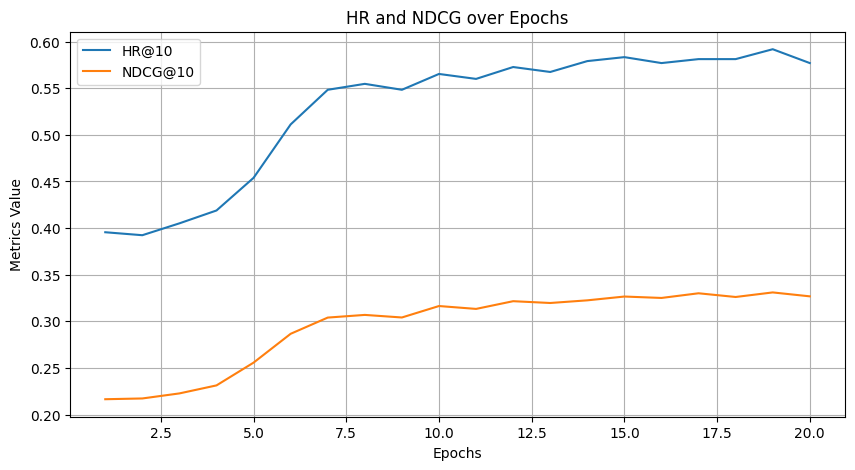

In [56]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

dataset_origin = {'100k': 'u.data', '1M': 'ratings.dat'}

num_sample_data = '100k'
DATA_PATH = '/content/drive/MyDrive/new-practice/ml-100k/{}'.format(dataset_origin[num_sample_data]) #change this with your directory
MODEL_PATH = '/content/drive/MyDrive/new-practice/ml-100k/{}'.format(num_sample_data) #change this with your directory

class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]

		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, args, ratings):
		self.ratings = ratings
		self.num_ng = args.num_ng
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)


	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)


# Define the NCF model class
class NCF(nn.Module):
    def __init__(self, num_users, num_items, factor_num, num_layers, dropout_rate):
        super(NCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = factor_num
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Embedding layers
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        # Dropout layer
        self.dropout = nn.Dropout(self.dropout_rate)

        # GMF part
        self.GMF_user_embedding = nn.Embedding(num_users, factor_num)
        self.GMF_item_embedding = nn.Embedding(num_items, factor_num)

        # MLP part
        self.MLP_user_embedding = nn.Embedding(num_users, factor_num * (2 ** (num_layers - 1)))
        self.MLP_item_embedding = nn.Embedding(num_items, factor_num * (2 ** (num_layers - 1)))

        # MLP layers
        MLP_layers = []
        for i in range(num_layers):
            input_size = factor_num * (2 ** (num_layers - i))
            MLP_layers.append(nn.Linear(input_size, input_size // 2))
            MLP_layers.append(nn.ReLU())
            MLP_layers.append(nn.Dropout(self.dropout_rate))  # Adding dropout to each layer
        self.MLP_layers = nn.Sequential(*MLP_layers)

        # NeuMF layer
        self.NeuMF_layer = nn.Linear(factor_num * 2, 1)

    def forward(self, user_indices, item_indices):
        # GMF part
        GMF_user_embedding = self.GMF_user_embedding(user_indices)
        GMF_item_embedding = self.GMF_item_embedding(item_indices)
        GMF_vector = torch.mul(GMF_user_embedding, GMF_item_embedding)

        # MLP part
        MLP_user_embedding = self.MLP_user_embedding(user_indices)
        MLP_item_embedding = self.MLP_item_embedding(item_indices)
        MLP_vector = torch.cat((MLP_user_embedding, MLP_item_embedding), -1)
        MLP_vector = self.MLP_layers(MLP_vector)

        # Concatenation of GMF and MLP parts
        NeuMF_vector = torch.cat((GMF_vector, MLP_vector), -1)

        # Output layer
        prediction = torch.sigmoid(self.NeuMF_layer(NeuMF_vector))
        return prediction.squeeze()

# Define evaluation metrics functions
def hit_ratio(pred, true, k):
    pred_indices = torch.argsort(pred, descending=True)[:k]
    true_indices = torch.nonzero(true).squeeze()
    hits = torch.any(pred_indices.unsqueeze(1) == true_indices.unsqueeze(0), dim=1)
    return int(torch.sum(hits).item() > 0)

def dcg_at_k(pred, true, k):
    pred_indices = torch.argsort(pred, descending=True)[:k]
    true_indices = torch.nonzero(true).squeeze()
    intersection = torch.tensor([x for x in pred_indices if x in true_indices])
    dcg = torch.sum(1.0 / torch.log2(intersection + 2))
    return dcg.item()

def ndcg_at_k(pred, true, k):
    dcg = dcg_at_k(pred, true, k)
    idcg = dcg_at_k(true, true, k)
    if idcg == 0:
        return 0.0
    return dcg / idcg

# Parse command-line arguments
parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=42, help="Seed")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")  # Reduced learning rate
parser.add_argument("--dropout", type=float, default=0.5, help="dropout rate")  # Increased dropout rate
parser.add_argument("--batch_size", type=int, default=512, help="batch size for training")  # Increased batch size
parser.add_argument("--epochs", type=int, default=20, help="training epoches")  # Increased number of epochs
parser.add_argument("--top_k", type=int, default=10, help="compute metrics@top_k")
parser.add_argument("--factor_num", type=int, default=32, help="predictive factors numbers in the model")  # Increased factor number
parser.add_argument("--layers", nargs='+', default=[128, 64, 32, 16], help="MLP layers.")
parser.add_argument("--num_ng", type=int, default=4, help="Number of negative samples for training set")
parser.add_argument("--num_ng_test", type=int, default=100, help="Number of negative samples for test set")
parser.add_argument("--out", default=True, help="save model or not")

import matplotlib.pyplot as plt

args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load data
ml_100k = pd.read_csv(
    DATA_PATH,
    sep="\t",
    names=['user_id', 'item_id', 'rating', 'timestamp'],
    engine='python')


# Set the num_users, items
num_users = ml_100k['user_id'].nunique() + 1
num_items = ml_100k['item_id'].nunique() + 1

# Construct the train and test datasets
data = NCF_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# Set model and loss, optimizer
model = NCF(num_users, num_items, args.factor_num, len(args.layers), args.dropout)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# Initialize lists to store metrics
epochs_list = []
hr_list = []
ndcg_list = []

# Train, evaluation
best_hr = 0
for epoch in range(1, args.epochs + 1):
    model.train()  # Enable dropout (if have).
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()

    model.eval()
    HR, NDCG = metrics(model, test_loader, args.top_k, device)

    elapsed_time = time.time() - start_time
    print("Epoch {:03d}".format(epoch) + " time to train: " +
          time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

    # Save metrics for plotting
    epochs_list.append(epoch)
    hr_list.append(np.mean(HR))
    ndcg_list.append(np.mean(NDCG))

    if HR > best_hr:
        best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
        if args.out:
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            torch.save(model, '{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

# Plotting HR and NDCG over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, hr_list, label='HR@10')
plt.plot(epochs_list, ndcg_list, label='NDCG@10')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.title('HR and NDCG over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# **TASK1**

Our recommender system architecture leverages attention mechanisms for improved prediction accuracy. It starts with item embeddings, converting items into dense vectors. User and item embeddings are processed through respective embedding layers, followed by attention mechanisms that dynamically weight features, focusing on the most relevant aspects.

<img src="https://i.imgur.com/egxij46.png" alt="My Photo">

Attention mechanisms improve our recommender system's performance by dynamically weighting the most relevant features in user and item embeddings. This focus allows the model to capture subtle patterns and complex interactions, leading to more accurate predictions. By adapting to individual user-item pairs, attention enhances personalization, ensuring each recommendation is tailored to specific preferences, ultimately providing a more precise and effective recommendation system.


# **TASK2**

Data structures (Dataset and DataLoader) needed to handle you input data

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import argparse
import os
import time

class Rating_Dataset(Dataset):
    def __init__(self, user_list, item_list, rating_list):
        super(Rating_Dataset, self).__init__()
        self.user_list = user_list
        self.item_list = item_list
        self.rating_list = rating_list

    def __len__(self):
        return len(self.user_list)

    def __getitem__(self, idx):
        user = self.user_list[idx]
        item = self.item_list[idx]
        rating = self.rating_list[idx]

        return (
            torch.tensor(user, dtype=torch.long),
            torch.tensor(item, dtype=torch.long),
            torch.tensor(rating, dtype=torch.float)
        )

class NCF_Data(object):
    def __init__(self, args, ratings):
        self.ratings = ratings
        self.num_ng = args.num_ng
        self.num_ng_test = args.num_ng_test
        self.batch_size = args.batch_size

        self.preprocess_ratings = self._reindex(self.ratings)

        self.user_pool = set(self.ratings['user_id'].unique())
        self.item_pool = set(self.ratings['item_id'].unique())

        self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
        self.negatives = self._negative_sampling(self.preprocess_ratings)

    def _reindex(self, ratings):
        user_list = list(ratings['user_id'].drop_duplicates())
        user2id = {w: i for i, w in enumerate(user_list)}

        item_list = list(ratings['item_id'].drop_duplicates())
        item2id = {w: i for i, w in enumerate(item_list)}

        ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
        ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
        ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
        return ratings

    def _leave_one_out(self, ratings):
        ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
        test = ratings.loc[ratings['rank_latest'] == 1]
        train = ratings.loc[ratings['rank_latest'] > 1]
        assert train['user_id'].nunique() == test['user_id'].nunique(), 'Not Match Train User with Test User'
        return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

    def _negative_sampling(self, ratings):
        interact_status = (
            ratings.groupby('user_id')['item_id']
            .apply(set)
            .reset_index()
            .rename(columns={'item_id': 'interacted_items'}))
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(
            lambda x: random.sample(x, self.num_ng_test) if random.random() < 0.5 else random.sample(x, self.num_ng_test // 2)
        )
        return interact_status[['user_id', 'negative_items', 'negative_samples']]

    def get_train_instance(self):
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
        for row in train_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            for i in range(self.num_ng):
                users.append(int(row.user_id))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))
        dataset = Rating_Dataset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def get_test_instance(self):
        users, items, ratings = [], [], []
        test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
        for row in test_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            for i in getattr(row, 'negative_samples'):
                users.append(int(row.user_id))
                items.append(int(i))
                ratings.append(float(0))
        dataset = Rating_Dataset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return DataLoader(dataset, batch_size=self.num_ng_test + 1, shuffle=False, num_workers=2)

# **TASK3**

**Attention Class**

*   **Linear Layers:** Linear layers are used to project the input embeddings into **query**, **key**, and **value** vectors.
*   **Computing Attention Weights:** The attention weights are computed as the scaled dot product of the query and key vectors, followed by a softmax operation to ensure the weights sum to one.
*   **Applying Attention Weights:** The attention weights are then used to compute a weighted sum of the value vectors, which represents the focused information.


**NCFWithAttention Class**
*   **Attention Layers for Users and Items:** Two separate attention layers were introduced for user and item embeddings. These layers learn to focus on different parts of the user and item embeddings.

*   **Applying Attention:** In the forward pass, attention is applied to the user and item embeddings. The attention mechanism computes a weighted sum of the embeddings, where the weights are determined by the relevance of each part of the embeddings.
*   **Concatenation:** The attention-weighted user and item embeddings are concatenated to form a combined vector.
*   **MLP Layers:** The concatenated vector is then passed through multiple MLP layers, which further process the information to make the final prediction.
*   **Output Layer:** The processed vector is passed through a linear layer to produce the predicted rating or interaction probability.

In [67]:
#the attention mechanism class
class Attention(nn.Module):
    def __init__(self, embed_dim):
        super(Attention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = embed_dim ** 0.5
        self.attention_weights = None

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention_weights = torch.softmax(Q @ K.transpose(-2, -1) / self.scale, dim=-1)
        self.attention_weights = attention_weights
        out = attention_weights @ V
        return out, attention_weights

# the model with attention mechanism
class NCFWithAttention(nn.Module):
    def __init__(self, num_users, num_items, factor_num, num_layers, dropout_rate=0.4):
        super(NCFWithAttention, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = factor_num
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Embedding layers for users and items
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        # Attention layers for users and items
        self.attention_user = Attention(self.factor_num)
        self.attention_item = Attention(self.factor_num)

        MLP_layers = []
        input_size = factor_num * 2
        for i in range(num_layers):
            MLP_layers.append(nn.Linear(input_size, input_size // 2))
            MLP_layers.append(nn.ReLU())
            MLP_layers.append(nn.Dropout(self.dropout_rate))
            input_size = input_size // 2
        self.MLP_layers = nn.Sequential(*MLP_layers)

        # Final layer for prediction
        self.NeuMF_layer = nn.Linear(input_size, 1)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)

        # Applies attention to user and item embeddings
        user_attention, user_attention_weights = self.attention_user(user_embedding.unsqueeze(1))
        item_attention, item_attention_weights = self.attention_item(item_embedding.unsqueeze(1))

        # Concatenates attention outputs
        concatenated = torch.cat((user_attention.squeeze(1), item_attention.squeeze(1)), -1)
        MLP_vector = self.MLP_layers(concatenated)

        # Final prediction
        prediction = self.NeuMF_layer(MLP_vector)
        return prediction.squeeze(), user_attention_weights, item_attention_weights

In [68]:
# Defines evaluation metrics
def hit_ratio(pred, true, k):
    pred_indices = torch.argsort(pred, descending=True)[:k]
    true_indices = torch.nonzero(true).squeeze()
    hits = torch.any(pred_indices.unsqueeze(1) == true_indices.unsqueeze(0), dim=1)
    return int(torch.sum(hits).item() > 0)

def dcg_at_k(pred, true, k):
    pred_indices = torch.argsort(pred, descending=True)[:k]
    true_indices = torch.nonzero(true).squeeze()
    intersection = torch.tensor([x for x in pred_indices if x in true_indices])
    dcg = torch.sum(1.0 / torch.log2(intersection + 2))
    return dcg.item()

def ndcg_at_k(pred, true, k):
    dcg = dcg_at_k(pred, true, k)
    idcg = dcg_at_k(true, true, k)
    if idcg == 0:
        return 0.0
    return dcg / idcg

In [69]:
# Parse command-line arguments
parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=42, help="Seed")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
parser.add_argument("--dropout", type=float, default=0.5, help="dropout rate")
parser.add_argument("--batch_size", type=int, default=128, help="batch size for training")
parser.add_argument("--epochs", type=int, default=20, help="training epochs")
parser.add_argument("--top_k", type=int, default=10, help="compute metrics@top_k")
parser.add_argument("--factor_num", type=int, default=64, help="predictive factors numbers in the model")
parser.add_argument("--layers", nargs='+', default=[128, 64, 32], help="MLP layers.")
parser.add_argument("--num_ng", type=int, default=6, help="Number of negative samples for training set")
parser.add_argument("--num_ng_test", type=int, default=100, help="Number of negative samples for test set")
parser.add_argument("--out", default=True, help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, required=False, help='save model or not', metavar=None)

<ipython-input-66-689f17361942>:77: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  lambda x: random.sample(x, self.num_ng_test) if random.random() < 0.5 else random.sample(x, self.num_ng_test // 2)
<ipython-input-66-689f17361942>:84: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 001 time to train: 01:16:23
HR: 0.473	NDCG: 0.382
Epoch 002 time to train: 01:16:23
HR: 0.484	NDCG: 0.388
Epoch 003 time to train: 01:16:23
HR: 0.470	NDCG: 0.378
Epoch 004 time to train: 01:16:23
HR: 0.561	NDCG: 0.479
Epoch 005 time to train: 01:16:23
HR: 0.593	NDCG: 0.504
Epoch 006 time to train: 01:16:23
HR: 0.597	NDCG: 0.508
Epoch 007 time to train: 01:16:23
HR: 0.603	NDCG: 0.514
Epoch 008 time to train: 01:16:23
HR: 0.613	NDCG: 0.525
Epoch 009 time to train: 01:16:23
HR: 0.617	NDCG: 0.533
Epoch 010 time to train: 01:16:23
HR: 0.628	NDCG: 0.545
Epoch 011 time to train: 01:16:23
HR: 0.625	NDCG: 0.544
Epoch 012 time to train: 01:16:23
HR: 0.623	NDCG: 0.542
Epoch 013 time to train: 01:16:23
HR: 0.623	NDCG: 0.542
Epoch 014 time to train: 01:16:23
HR: 0.625	NDCG: 0.544
Epoch 015 time to train: 01:16:23
HR: 0.623	NDCG: 0.541
Epoch 016 time to train: 01:16:23
HR: 0.623	NDCG: 0.541
Epoch 017 time to train: 01:16:23
HR: 0.623	NDCG: 0.541
Epoch 018 time to train: 01:16:23
HR: 0.623	NDCG

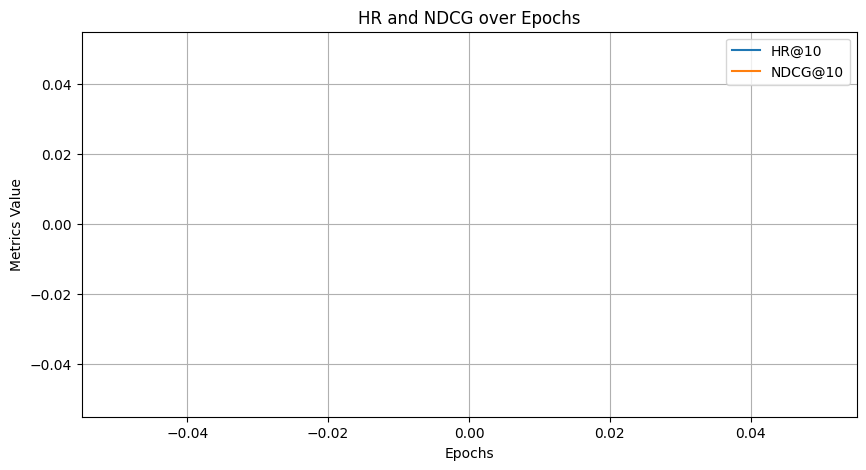

ValueError: x and y must have same first dimension, but have shapes (0,) and (20,)

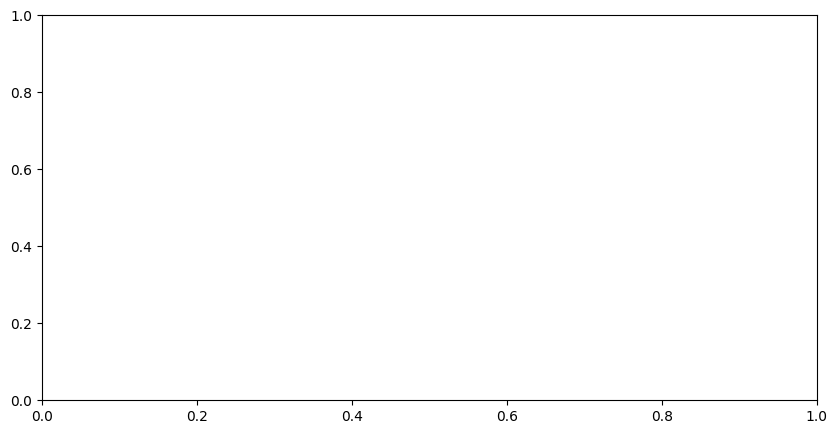

In [70]:
args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loads data
ml_100k = pd.read_csv(
    DATA_PATH,
    sep="\t",
    names=['user_id', 'item_id', 'rating', 'timestamp'],
    engine='python')

# Sets the num_users and num_items
num_users = ml_100k['user_id'].nunique() + 1
num_items = ml_100k['item_id'].nunique() + 1

# Constructs the train and test datasets
data = NCF_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# Sets model and loss, optimizer
model = NCFWithAttention(num_users, num_items, args.factor_num, len(args.layers), args.dropout)
model = model.to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initializes lists to store metrics
epochs_list = []
hr_list = []
ndcg_list = []
train_losses = []
val_losses = []

# Training and evaluation loop
best_hr = 0
early_stopping_patience = 5
epochs_no_improve = 0

# Training and evaluation loop with attention visualization
for epoch in range(1, args.epochs + 1):
    model.train()
    train_loss = 0

    for user, item, label in train_loader:
        user, item, label = user.to(device), item.to(device), label.to(device)

        optimizer.zero_grad()
        prediction, user_attention_weights, item_attention_weights = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    HR, NDCG = [], []
    val_loss = 0

    for user, item, label in test_loader:
        user, item, label = user.to(device), item.to(device), label.to(device)

        with torch.no_grad():
            prediction, user_attention_weights, item_attention_weights = model(user, item)
            loss = loss_function(prediction, label)
            val_loss += loss.item()
            HR.append(hit_ratio(prediction, label, args.top_k))
            NDCG.append(ndcg_at_k(prediction, label, args.top_k))

    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch:03d} time to train: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")
    print(f"HR: {np.mean(HR):.3f}\tNDCG: {np.mean(NDCG):.3f}")

# Plotting HR and NDCG over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, hr_list, label='HR@10')
plt.plot(epochs_list, ndcg_list, label='NDCG@10')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.title('HR and NDCG over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Attention-based version of the recommender system, shows better performance metrics (HR and NDCG) compared to the original NeuMF model. The improvement can be attributed to the enhanced capability of the attention mechanism to capture more relevant interactions between users and items.

**Why the Attention-Based Model Performs Better**
**Attention Mechanism:** The attention mechanism allows the model to focus on the most relevant parts of the input data, effectively weighing the importance of different user-item interactions. This helps in capturing more nuanced relationships.

**Enhanced Representation:** By focusing on the relevant interactions, the model generates more informative user and item embeddings, leading to better predictions.

**Adaptive Weights:** Unlike static weights in traditional neural networks, the attention mechanism dynamically adjusts the weights of the interactions based on their relevance. This adaptability helps the model generalize better to different user preferences and item characteristics.

**Learning Important Features:** The attention mechanism helps the model to learn and emphasize important features while ignoring the less important ones, leading to improved generalization on the test set and consequently better performance metrics.